# Comparing Forecasts on Major League Baseball (MLB) Games

We compare probability forecasts on the outcome of all MLB games from 2010 to 2019, culminating with the [2019 World Series](https://en.wikipedia.org/wiki/2019_World_Series) between Houston Astros and Washington Nationals. 

The 2019 World Series is an interesting test case, as the Nationals defied the odds given by many professional forecasters and baseball experts and won 4-3.
It was also the only major championship series across North American sports where the visiting team won all games. 
We compare various forecasters that made forecasts game-by-game and compare their performances.

Since this is a post-hoc analysis, we optimize our bounds to be the tightest at the last time step (corresponding to the final game of the 2019 World Series).


YJ Choe [yjchoe@cmu.edu]

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import comparecast as cc

%matplotlib inline

In [2]:
# significance level
ALPHA = 0.05
V_OPT = None  # optimize at the final step

## Data

We use three sets of forecasts on the outcome of MLB games from 2010 to 2019, leading up to the final seven World Series games. 
The three forecasts are:
- FiveThirtyEight's win probability projection using the new method (`fivethirtyeight`);
- Closing odds converted to probabilities (source: [Vegas-Odds.com](Vegas-Odds.com)) (`vegas`);
- Various simple baselines from our synthetic experiments (`random`, `laplace`, `k29`).

We make use of [FiveThirtyEight's MLB records](https://github.com/fivethirtyeight/data/tree/6f5b4898481a71cd85ea3c03bb1613dd4a43275b/mlb-elo) as well as its predictions.
The event of interest is defined as whether the Nationals win each game.  
For forecasting algorithms, we use all Nationals games (regular season & postseason) from 2010 to 2019.

## Retrieve FiveThirtyEight Data + Precompute Baselines

In [3]:
team = "MLB"
start_year, end_year = 2010, 2019
plots_dir = f"./plots/{team.lower()}_{start_year}_{end_year}"
os.makedirs(plots_dir, exist_ok=True)

save_file = "data/mlb_elo_538_with_baselines.csv"
data = cc.data_utils.baseball.preprocess_mlb_baselines(2010, 2019, save_file=save_file)  # all years, all teams
data.tail(10)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,constant_log5_prob1,constant_log5_prob2,laplace_prob1,laplace_prob2,laplace_log5_prob1,laplace_log5_prob2,k29_prob1,k29_prob2,k29_log5_prob1,k29_log5_prob2
24643,2019-10-17,2019,0,l,NYY,HOU,1588.485661,1596.138896,0.531325,0.468675,...,0.5,0.5,0.489317,0.510683,0.470134,0.529866,0.433361,0.566639,0.344239,0.655761
24644,2019-10-18,2019,0,l,NYY,HOU,1583.765417,1600.859140,0.513249,0.486751,...,0.5,0.5,0.491614,0.508386,0.476600,0.523400,0.395641,0.604359,0.264351,0.735649
24645,2019-10-19,2019,0,l,HOU,NYY,1597.688468,1586.936089,0.566291,0.433709,...,0.5,0.5,0.510594,0.489406,0.529484,0.470516,0.546807,0.453193,0.604763,0.395237
24646,2019-10-22,2019,0,w,HOU,WSN,1599.986054,1583.920128,0.576279,0.423721,...,0.5,0.5,0.526322,0.473678,0.568647,0.431353,0.425938,0.574062,0.202305,0.797695
24647,2019-10-23,2019,0,w,HOU,WSN,1597.491698,1586.414484,0.566903,0.433097,...,0.5,0.5,0.523909,0.476091,0.562296,0.437704,0.387541,0.612459,0.116234,0.883766
24648,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,0.5,0.5,0.473915,0.526085,0.432201,0.567799,0.643192,0.356808,0.931715,0.068285
24649,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,0.5,0.5,0.471759,0.528241,0.426778,0.573222,0.556748,0.443252,0.652762,0.347238
24650,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,0.5,0.5,0.469623,0.530377,0.421435,0.578565,0.500801,0.499199,0.502051,0.497949
24651,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,0.5,0.5,0.527989,0.472011,0.572335,0.427665,0.545380,0.454620,0.611294,0.388706
24652,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,...,0.5,0.5,0.525623,0.474377,0.566166,0.433834,0.494966,0.505034,0.487959,0.512041


In [4]:
# home win probability
data["win"] = (data["score1"] >= data["score2"]).astype(int)
data["data"] = data["win"]
data["time"] = data.groupby(["date", "team1", "team2"]).ngroup(ascending=True) + 1
data.sort_values("time", inplace=True)

forecasters = [f + "_prob1" for f in ["rating", "elo", "constant", "laplace", "k29"]]
data = data[["date", "season", "playoff", "team1", "team2", 
             "score1", "score2", "time", "data", "win"] + forecasters].copy()
data.rename(lambda x: {
    "rating_prob1": "fivethirtyeight",
    "elo_prob1": "fivethirtyeight_old",
    "constant_prob1": "constant",
    "laplace_prob1": "laplace",
    "k29_prob1": "k29",
}.get(x, x), axis=1, inplace=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,data,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29
24639,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.506207,0.475183
24640,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.513904,0.643804
24642,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.491545,0.476309
24641,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.516385,0.674184
24643,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.489317,0.433361
24644,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.491614,0.395641
24645,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.510594,0.546807
24646,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.526322,0.425938
24647,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.523909,0.387541
24648,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.473915,0.643192


## Process Vegas Odds & Combine with the FiveThirtyEight Data

Source: https://sports-statistics.com/sports-data/mlb-historical-odds-scores-datasets/

In [5]:
vegas_odds = cc.data_utils.baseball.read_vegas_odds(start_year, end_year, team)
vegas_odds.tail(7)

,date,team1,pitcher1,final1,open1,close1,team2,pitcher2,final2,open2,...,open_prob1,open_prob2,open_log5_prob1,open_log5_prob2,close_iprob1,close_iprob2,close_prob1,close_prob2,close_log5_prob1,close_log5_prob2
24642,2019-10-22,HOU,GCOLE-R,4,-200,-200.0,WAS,MSCHERZER-R,5,179,...,0.650350,0.349650,0.775765,0.224235,0.666667,0.357143,0.651163,0.348837,0.777007,0.222993
24643,2019-10-23,HOU,JVERLANDER-R,3,-175,-172.0,WAS,SSTRASBURG-R,12,157,...,0.620559,0.379441,0.727870,0.272130,0.632353,0.383142,0.622704,0.377296,0.731468,0.268532
24644,2019-10-25,WAS,ASANCHEZ-R,1,110,140.0,HOU,ZGREINKE-R,4,-121,...,0.465165,0.534835,0.430667,0.569333,0.416667,0.600000,0.409836,0.590164,0.325351,0.674649
24645,2019-10-26,WAS,PCORBIN-L,1,-115,-108.0,HOU,JURQUIDY-R,8,105,...,0.523017,0.476983,0.545937,0.454063,0.519231,0.504950,0.506972,0.493028,0.513940,0.486060
24646,2019-10-27,WAS,MSCHERZER-R,1,140,190.0,HOU,GCOLE-R,7,-155,...,0.406699,0.593301,0.319676,0.680324,0.344828,0.677419,0.337323,0.662677,0.205790,0.794210
24647,2019-10-29,HOU,JVERLANDER-R,2,-180,-176.0,WAS,SSTRASBURG-R,7,162,...,0.627461,0.372539,0.739367,0.260633,0.637681,0.380228,0.626462,0.373538,0.737717,0.262283
24648,2019-10-30,HOU,ZGREINKE-R,2,-135,-138.0,WAS,MSCHERZER-R,6,122,...,0.560501,0.439499,0.619256,0.380744,0.579832,0.438596,0.569340,0.430660,0.636063,0.363937


In [6]:
map_teamcodes = {
    v: t for t, vs in cc.data_utils.baseball.TEAM_CODES.items() 
    for v in vs
}
for column in ["team1", "team2"]:
    vegas_odds[column] = vegas_odds[column].apply(lambda x: map_teamcodes[x])

In [7]:
forecasters = [f + "_prob1" for f in ["open", "close"]]
vegas_odds = vegas_odds[["date", "team1", "team2",] + forecasters].copy()
vegas_odds.rename(lambda x: {
    "open_prob1": "vegas_open",
    "close_prob1": "vegas",
}.get(x, x), axis=1, inplace=True)
vegas_odds.tail(14)

,date,team1,team2,vegas_open,vegas
24635,2019-10-13,HOU,NYY,0.600246,0.624596
24636,2019-10-14,WSN,STL,0.544024,0.546330
24638,2019-10-15,WSN,STL,0.593301,0.606061
24637,2019-10-15,NYY,HOU,0.399754,0.401733
24639,2019-10-17,NYY,HOU,0.544024,0.560037
24640,2019-10-18,NYY,HOU,0.431344,0.427046
24641,2019-10-19,HOU,NYY,0.568656,0.529605
24642,2019-10-22,HOU,WSN,0.650350,0.651163
24643,2019-10-23,HOU,WSN,0.620559,0.622704
24644,2019-10-25,WSN,HOU,0.465165,0.409836


In [8]:
data = data.merge(vegas_odds, on=["date", "team1", "team2"], sort=True)
data.tail(14)

,date,season,playoff,team1,team2,score1,score2,time,data,win,fivethirtyeight,fivethirtyeight_old,constant,laplace,k29,vegas_open,vegas
25151,2019-10-13,2019,l,HOU,NYY,3.0,2.0,24377,1,1,0.572595,0.539407,0.5,0.506207,0.475183,0.600246,0.624596
25152,2019-10-14,2019,l,WSN,STL,8.0,1.0,24378,1,1,0.548193,0.597434,0.5,0.513904,0.643804,0.544024,0.546330
25153,2019-10-15,2019,l,NYY,HOU,1.0,4.0,24379,0,0,0.487959,0.545260,0.5,0.491545,0.476309,0.399754,0.401733
25154,2019-10-15,2019,l,WSN,STL,7.0,4.0,24380,1,1,0.630898,0.612518,0.5,0.516385,0.674184,0.593301,0.606061
25155,2019-10-17,2019,l,NYY,HOU,3.0,8.0,24381,0,0,0.567884,0.531325,0.5,0.489317,0.433361,0.544024,0.560037
25156,2019-10-18,2019,l,NYY,HOU,4.0,1.0,24382,1,1,0.491436,0.513249,0.5,0.491614,0.395641,0.431344,0.427046
25157,2019-10-19,2019,l,HOU,NYY,6.0,4.0,24383,1,1,0.543097,0.566291,0.5,0.510594,0.546807,0.568656,0.529605
25158,2019-10-22,2019,w,HOU,WSN,4.0,5.0,24384,0,0,0.620572,0.576279,0.5,0.526322,0.425938,0.650350,0.651163
25159,2019-10-23,2019,w,HOU,WSN,3.0,12.0,24385,0,0,0.590066,0.566903,0.5,0.523909,0.387541,0.620559,0.622704
25160,2019-10-25,2019,w,WSN,HOU,1.0,4.0,24386,0,0,0.526852,0.553044,0.5,0.473915,0.643192,0.465165,0.409836


In [9]:
data.to_csv(f"forecasts/{team.lower()}_{start_year}_{end_year}.csv", index=False)

## Comparing All Forecasters

In [10]:
scoring_rule = "brier"

In [11]:
forecasters = ["fivethirtyeight", "vegas", "laplace", "k29", "constant"]

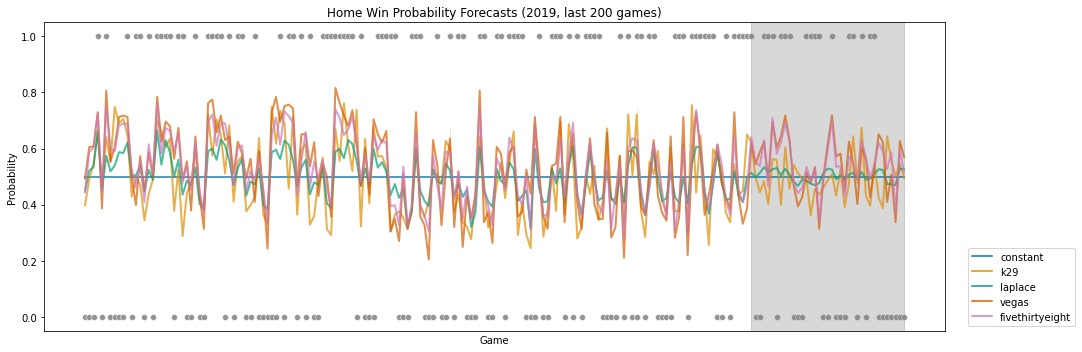

In [12]:
cc.plot_mlb_forecasts(
    data,
    team,
    [2019],
    forecasters[::-1],
    no_playoffs=False,
    window=("2019-10-01", "2019-10-30"),  # playoffs
    n_games=200,
    save_filename=os.path.join(plots_dir, f"forecasts.pdf"),
)

## Main Comparisons

In [13]:
import itertools

scoring_rule = "brier"
for name_p, name_q in itertools.combinations(forecasters, 2):
    lcbs, ucbs = cc.compare_forecasts(
            data,
            name_p,
            name_q,
            scoring_rule=scoring_rule,
            alpha=ALPHA,
            v_opt=V_OPT,
        )
    print(f"{name_p:15} vs. {name_q:15}: ({lcbs[-1]:8.5f}, {ucbs[-1]:8.5f})")

fivethirtyeight vs. vegas          : (-0.00267, -0.00060)
fivethirtyeight vs. laplace        : (-0.00982, -0.00664)
fivethirtyeight vs. k29            : ( 0.02091,  0.02753)
fivethirtyeight vs. constant       : ( 0.00568,  0.00933)
vegas           vs. laplace        : (-0.00840, -0.00478)
vegas           vs. k29            : ( 0.02240,  0.02931)
vegas           vs. constant       : ( 0.00717,  0.01110)
laplace         vs. k29            : ( 0.02939,  0.03550)
laplace         vs. constant       : ( 0.01419,  0.01727)
k29             vs. constant       : (-0.02017, -0.01327)


### Pairwise Comparisons

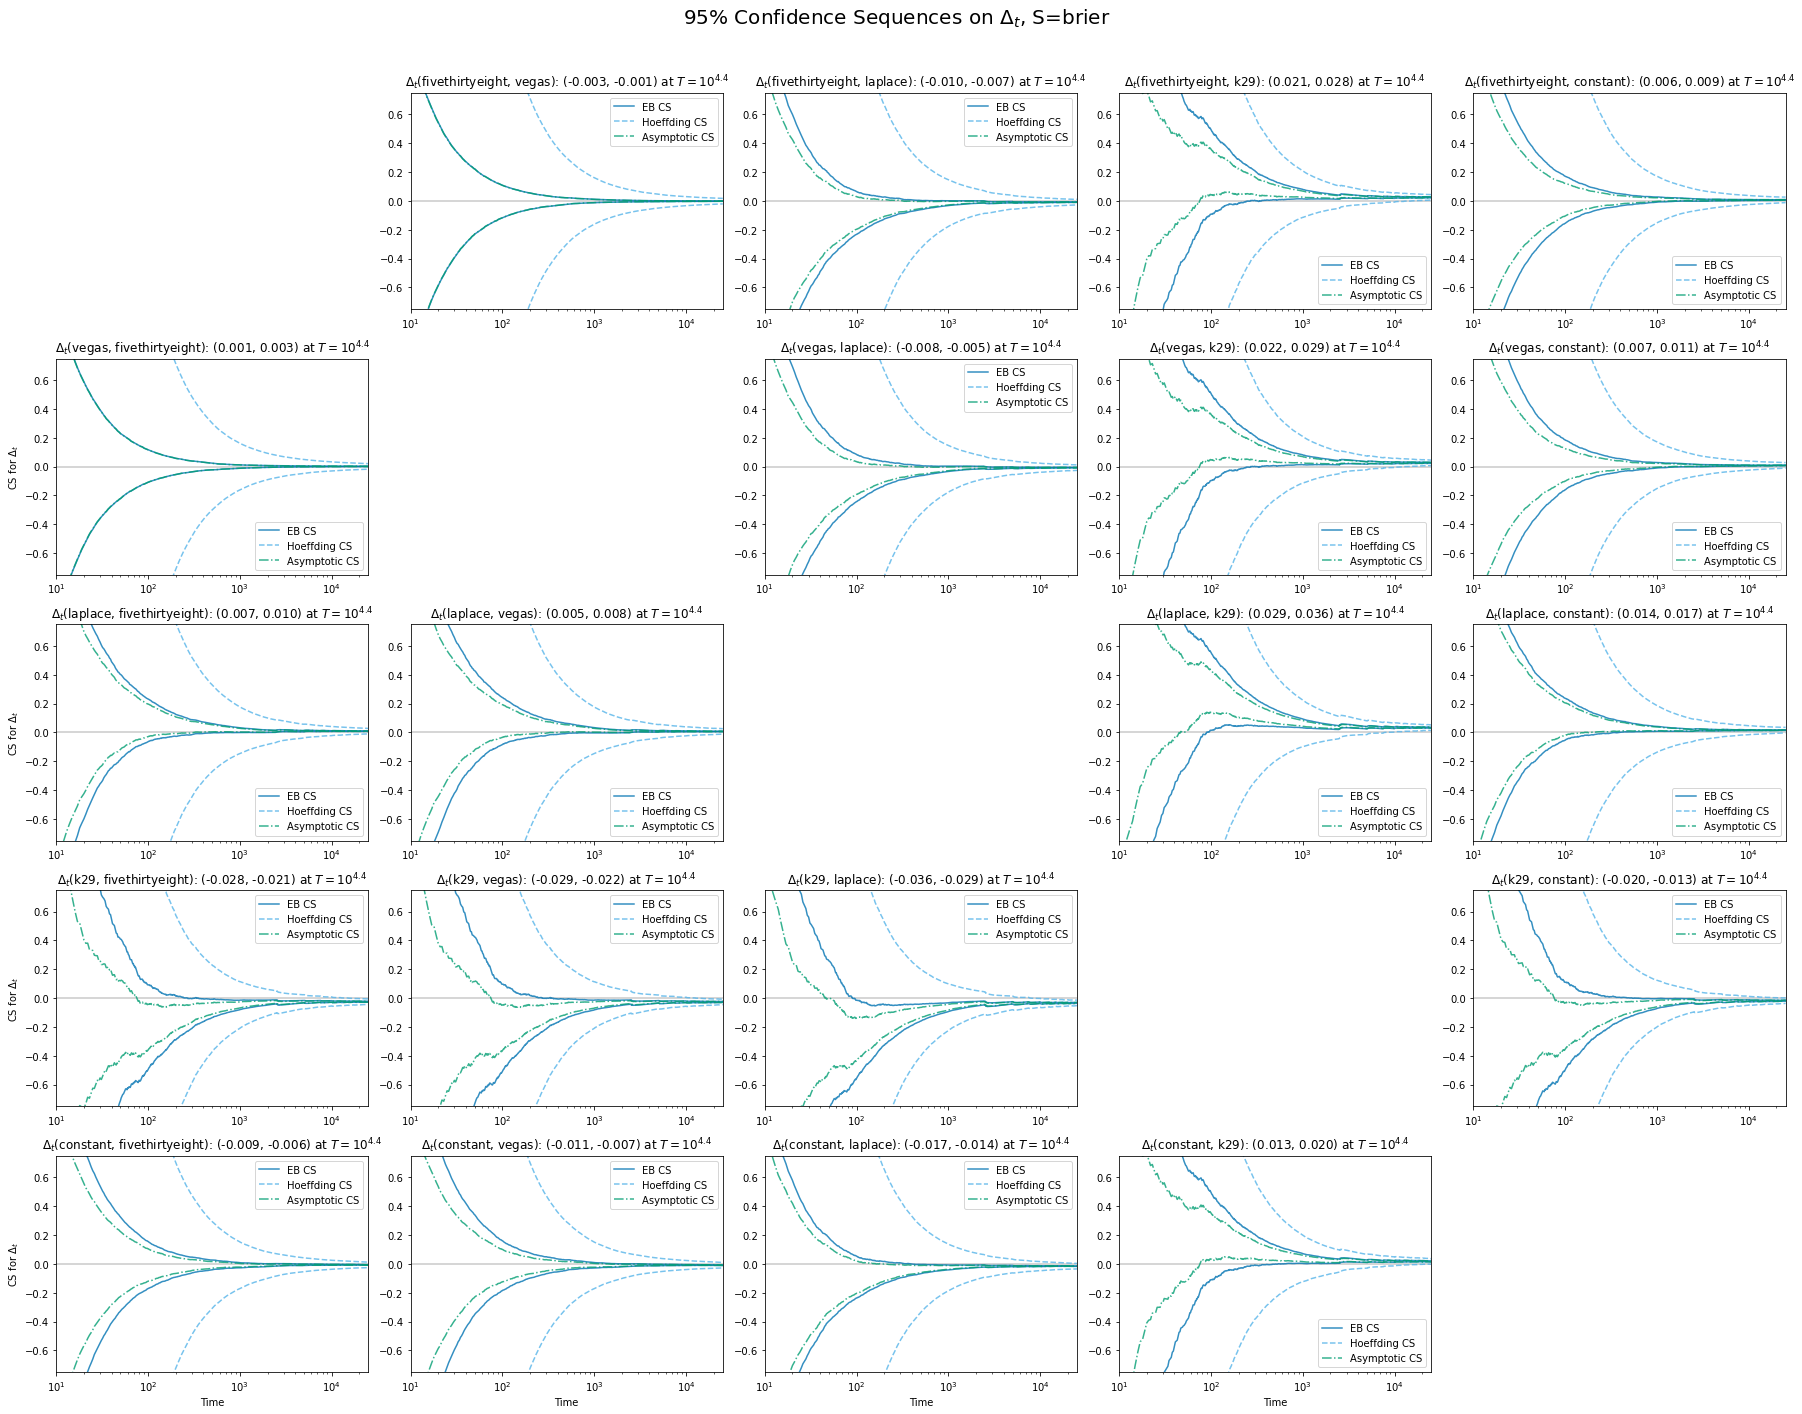

In [14]:
scoring_rule = "brier"
lo, hi = -1, 1
# scoring_rule = "logarithmic"
# lo, hi = np.log(0.01), -np.log(0.01)
ax = cc.plot_pairwise_comparisons(
    data, 
    forecasters, 
    scoring_rule=scoring_rule,
    alpha=ALPHA,
    lo=lo,
    hi=hi,
    v_opt=V_OPT,
    plots_dir=plots_dir,
    compare_baselines=("h", "acs"),
    use_logx=True,
)

### Comparison Against Laplace, i.e., the Rolling Season Average

In [15]:
def compare_against_baseline(data, forecasters, baseline, scoring_rule, save_csv=True, **kwargs):
    compdata = data[["date", "time", "data"] + forecasters].copy()
    for forecaster in forecasters:
        if forecaster == baseline:
            continue
        lcbs, ucbs = cc.compare_forecasts(
            data, 
            forecaster, 
            baseline, 
            scoring_rule=scoring_rule,
            **kwargs
        )
        compdata[f"{forecaster}_lcb"] = lcbs
        compdata[f"{forecaster}_ucb"] = ucbs
    if save_csv:
        compdata.to_csv(
            f"plots/{team}_{start_year}_{end_year}/{scoring_rule}_against_{baseline}.csv"
        )
    return compdata

In [16]:
compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline="laplace", 
    scoring_rule="brier",
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)
compdata.tail(7)

,date,time,data,fivethirtyeight,vegas,laplace,k29,constant,fivethirtyeight_lcb,fivethirtyeight_ucb,vegas_lcb,vegas_ucb,k29_lcb,k29_ucb,constant_lcb,constant_ucb
25158,2019-10-22,24384,0,0.620572,0.651163,0.526322,0.425938,0.5,-0.009808,-0.006629,-0.008398,-0.004778,-0.035503,-0.029393,-0.017275,-0.014193
25159,2019-10-23,24385,0,0.590066,0.622704,0.523909,0.387541,0.5,-0.009811,-0.006631,-0.008402,-0.004783,-0.035497,-0.029387,-0.017273,-0.014192
25160,2019-10-25,24386,0,0.526852,0.409836,0.473915,0.643192,0.5,-0.009812,-0.006633,-0.008400,-0.004780,-0.035503,-0.029393,-0.017274,-0.014192
25161,2019-10-26,24387,0,0.586974,0.506972,0.471759,0.556748,0.5,-0.009817,-0.006638,-0.008401,-0.004781,-0.035505,-0.029396,-0.017274,-0.014192
25162,2019-10-27,24388,0,0.373102,0.337323,0.469623,0.500801,0.5,-0.009813,-0.006634,-0.008396,-0.004777,-0.035505,-0.029396,-0.017275,-0.014193
25163,2019-10-29,24389,0,0.594638,0.626462,0.527989,0.545380,0.5,-0.009816,-0.006637,-0.008400,-0.004781,-0.035504,-0.029395,-0.017273,-0.014191
25164,2019-10-30,24390,0,0.515172,0.569340,0.525623,0.494966,0.5,-0.009815,-0.006636,-0.008402,-0.004783,-0.035501,-0.029393,-0.017271,-0.014190


$\LaTeX$

In [17]:
# Brier against laplace
scoring_rule = "brier"
baseline = "laplace"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        print(f"{forecaster:15s} & {lcb:8.5f} & {ucb:8.5f} \\\\")

fivethirtyeight & -0.00982 & -0.00664 \\
vegas           & -0.00840 & -0.00478 \\
k29             & -0.03550 & -0.02939 \\
constant        & -0.01727 & -0.01419 \\


In [18]:
# Winkler against laplace
scoring_rule = "winkler"
baseline = "laplace"

compdata = compare_against_baseline(
    data, 
    forecasters, 
    baseline=baseline, 
    scoring_rule=scoring_rule,
    save_csv=False,
    alpha=ALPHA,
    lo=-1,
    hi=1,
    v_opt=V_OPT,
)

for forecaster in forecasters:
    if forecaster != baseline:
        lcb = compdata[forecaster + "_lcb"].tail(1).item()
        ucb = compdata[forecaster + "_ucb"].tail(1).item()
        print(f"{forecaster:15s} & {lcb:8.5f} & {ucb:8.5f} \\\\")

fivethirtyeight & -0.06530 & -0.01727 \\
vegas           & -0.04213 &  0.00614 \\
k29             & -0.20991 & -0.15535 \\
constant        & -0.17520 & -0.13169 \\
